In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scripts.simulate_data import generate_slice

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 15

Presettings: We generate a linescanning dataset with:
1. 8 measurements (4 measurements higher bold response, 4 measurements lower bold response)
2. 10 repetitions a 30 seconds (10s pause - 10 seconds stimulus - 10 seconds pause)
3. sampling rate (SR) = 20

In [4]:
# load demo background
background = np.load("../demo/background.npz")["img"]

In [5]:
max_bold_change_first = 2.
max_bold_change_first = 4.

negative_bold_chage = -.3

repeats = 10

xt = np.linspace(- 5, 5, 200)


X = np.concatenate([generate_slice(1, max_bold_change=2, repeats=repeats,
                                      sampling_rate=10, negative_bold_chage=negative_bold_chage,
                                   cortical_peak=(10, 50)),
                    generate_slice(1, max_bold_change=10, repeats=repeats,
                                      sampling_rate=10, negative_bold_chage=negative_bold_chage,
                                   cortical_peak=(10, 50))], axis=0)
print(X.shape)

(2, 80, 80, 3000)


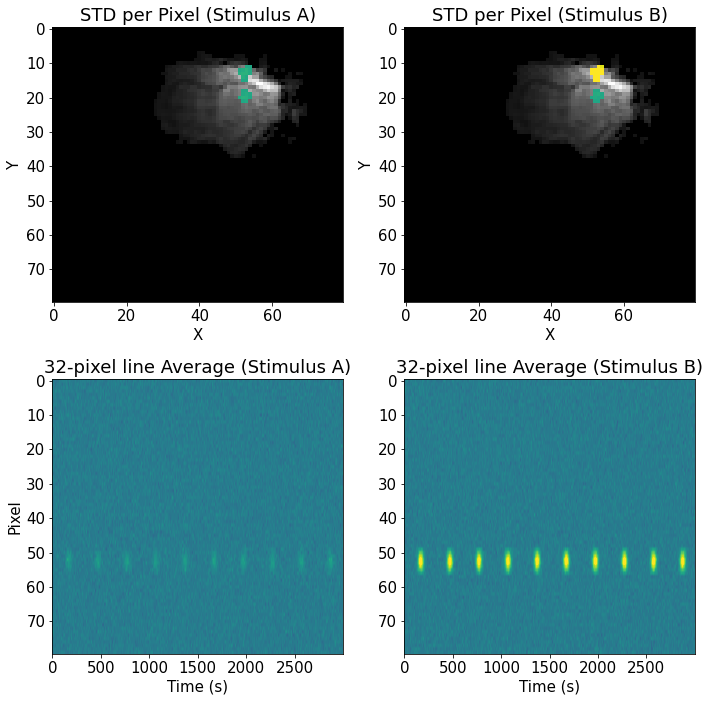

In [6]:
fig = plt.Figure((12, 12))
plt.subplot(221)
plt.title("STD per Pixel (Stimulus A)")
plt.imshow(background, cmap="binary_r")
plt.imshow(np.std(np.mean(X[:1, :, :, :], axis=0), axis=-1), aspect="auto",
           vmin=0, vmax=np.std(np.mean(X[:, :, :, :], axis=0), axis=-1).max(),
           alpha=(np.std(X[0, :, :, :], axis=-1)>.21).astype(float))
#plt.xticks(np.arange(np.shape(X)[2])[::2000], np.arange(np.shape(X)[2])[::2000]//20)
plt.ylabel("Y")
plt.xlabel("X")
plt.subplot(222)
plt.title("STD per Pixel (Stimulus B)")
plt.imshow(background, cmap="binary_r")
plt.imshow(np.std(np.mean(X[1:, :, :, :], axis=0), axis=-1), aspect="auto",
           vmin=0, vmax=np.std(np.mean(X[:, :, :, :], axis=0), axis=-1).max(),
           alpha=(np.std(X[0, :, :, :], axis=-1)>.21).astype(float))
#plt.xticks(np.arange(np.shape(X)[2])[::2000], np.arange(np.shape(X)[2])[::2000]//20)
plt.ylabel("Y")
plt.xlabel("X")


plt.subplot(223)
plt.title("32-pixel line Average (Stimulus A)")
plt.imshow(np.mean(X[:1, 12, :, :], axis=0), aspect="auto", vmin=0, vmax=np.mean(X[:, 12], axis=0).max())
#plt.xticks(np.arange(np.shape(X)[2])[::2000], np.arange(np.shape(X)[2])[::2000]//20)
plt.ylabel("Pixel")
plt.xlabel("Time (s)")
plt.subplot(224)
plt.imshow(np.mean(X[1:, 12, :, :], axis=0), aspect="auto", vmin=0, vmax=np.mean(X[:, 12], axis=0).max())
#plt.xticks(np.arange(np.shape(X)[2])[::2000], np.arange(np.shape(X)[2])[::2000]//20)
plt.xlabel("Time (s)")
plt.title("32-pixel line Average (Stimulus B)")
plt.tight_layout()
plt.show()

# Euclidean Clustering

In [7]:
# store all signals in a clusterable 2D-Array
X_aver = np.zeros(list(X.shape[:-1])+[300])
for k in range(len(X)):
    for i in range(10):
        X_aver[k] += X[k, :, :, 300*i:300*(i+1)]
X_aver /= 10
T = []
for q in range(len(X)):
    # iterate over all measurements
    for t0 in range(0, X_aver.shape[1]):
        for t1 in range(0, X_aver.shape[1]):
            # iterate over all pixels
            T.append(X_aver[q, t0, t1].reshape(1, -1))
T = np.concatenate(T, axis=0)

In [29]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
n_classes = 2
start, end = 100, 200  # interval to search the stimulus response

In [30]:
F = T[list(np.where(np.quantile(np.abs(T-1), 0.95, axis=1)>=0.2)[0])]

In [34]:
len(F)

94

In [31]:
distmat = (cdist(F[:, start:end], F[:, start:end], metric="correlation"))

In [32]:

cluster = AgglomerativeClustering(n_clusters=n_classes).fit_predict(distmat)

/Users/lucasplagwitz/miniforge3/envs/line_cluster/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [35]:
colors = np.array(["red", "blue", "white"])
allo = {}
for i in np.unique(cluster):
    allo[i] = np.max(np.mean(np.abs(F[cluster==i]), axis=0))
order = list({k: v for k, v in sorted(allo.items(), key=lambda item: item[1], reverse=True)}.keys())
#colors = colors[order]
cluster2 = cluster.copy()

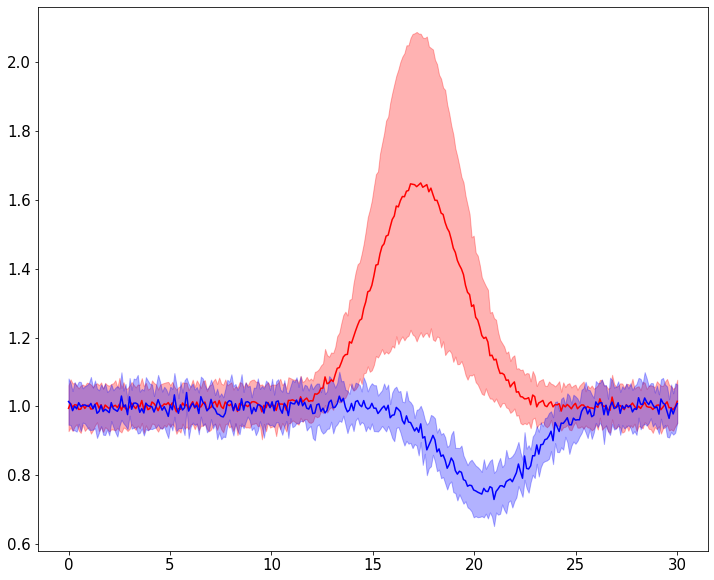

In [37]:
plt.rcParams['figure.figsize'] = [12, 10]
means = [np.mean(F[cluster==i], axis=0) for i in range(2)]
stds = [np.std(F[cluster==i], axis=0) for i in range(2)]
xx = np.linspace(0, 30, 300)
for i in range(2):
    plt.plot(xx, means[order[i]],color=colors[i])
    plt.fill_between(xx, means[order[i]]-stds[order[i]],
                     means[order[i]]+stds[order[i]], alpha=.3,color=colors[i])
plt.show()

In [39]:
R = np.zeros((80, 80, 2))
idxs = np.where(np.quantile(np.abs(T-1), 0.95, axis=1)>=0.2)[0]
k = 0
kk = 0
for ak in range(2):
    for i in range(80):
        for j in range(80):
            if k in idxs:
                R[j, i, ak] = cluster[kk] + 1
                kk += 1
            k += 1

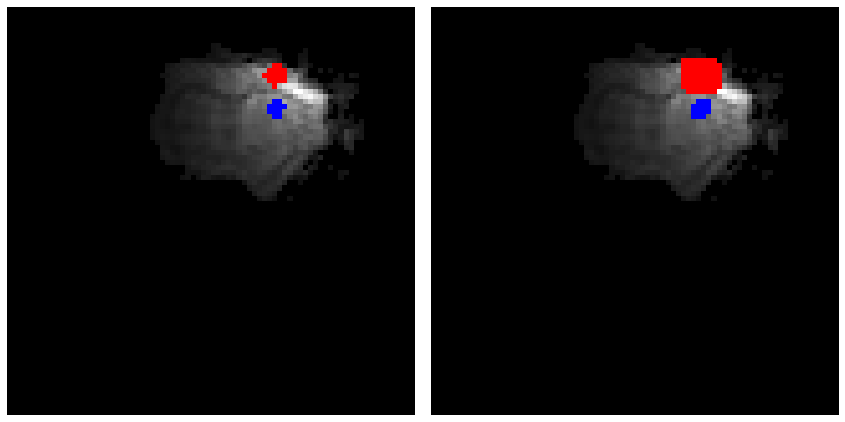

In [41]:
import matplotlib.colors as mcolors
plt.rcParams['figure.figsize'] = 12, 10
ord2 = [t for t in order if t != 3]
cmap_name = "custom_diverging"
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, ["white"] +
                                               colors[[np.where(np.array(order)==t)[0][0] for t in range(2)]].tolist(), N=3)
norm = mcolors.BoundaryNorm(boundaries=[0, 1, 2, 3,], ncolors=3)
oFig1 = plt.figure(1)
for i in range(2):
    oFig1.add_subplot(1,2,1+i)
    img = (R[:, :,i].T )   # fix this requirement
    plt.imshow(background, alpha=1 , cmap="binary_r")
    plt.imshow(img, cmap=cm, interpolation="none" , norm=norm, alpha=(img!=0).astype(float)
               )
    plt.axis("off")
plt.tight_layout()